First we will import all the requisite libraries 

In [5]:
#import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import LSTM
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from scipy import stats
import copy



Load the file
Each value in our dataset corresponds to the average expenditure by all the patients in a day on a medication
This value is calculated by summing the expenditures by all the patients on a day t and dividing this number by the total number of patients who bought medicine on day t.

In [6]:
fileName = '1b.csv'
data = read_csv(fileName)
dataAvg = [214.177329] #mean of data required to standardize the data
dataStd = [60.59258357] #standard deviation of data required to standardize the data
modelName = "lstm_recurrentdrop_B"   #required to save the model

create function to difference the time-series

In [7]:
nDiff = 1

#to make your data stationary and perform de-trending
def difference(data):
        return [data[i] - data[i - nDiff] for i in range(nDiff, len(data))]


Convert the data into supervised learning problem

In [8]:
def shiftData(data, lag, nOut = 1):
        dataOfOneColumn = DataFrame(data)
        dataOfOneColumnWithLag = list()
        for i in range(lag, 0, -1):
                dataOfOneColumnWithLag.append(dataOfOneColumn.shift(i))
        for i in range(0, nOut):
                dataOfOneColumnWithLag.append(dataOfOneColumn.shift(-i))
        dataOfOneColumnWithLag = concat(dataOfOneColumnWithLag, axis = 1)
        dataOfOneColumnWithLag.dropna(inplace = True)
        return dataOfOneColumnWithLag

Prepare the dataset for training

In [9]:
def prepareDataset(data, lag, numPoints):
        trainingData = list()
        flag = True
        for column in data.columns:
            dataOfOneColumnWithLag = np.array(shiftData(data[column], lag))[:numPoints]
            if flag == True:
                    trainingData = dataOfOneColumnWithLag
                    flag = False
                    continue
            trainingData = np.append(trainingData, dataOfOneColumnWithLag, axis = 0)
        return trainingData


Create function to train the model on training dataset

In [10]:
def train(trainingData, config):
        inputShape, numNode, numEpoch, batchSize = config
        if nDiff > 0:
                trainingData = np.array(difference(trainingData))
        trainX, trainY = trainingData[:, :-1], trainingData[:, -1]
        trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
        model = Sequential()
        model.add(LSTM(numNode, activation = 'relu', input_shape = (inputShape, 1),recurrent_dropout=0.2))
        #model.add(Dropout(0.2)) #you can either add a dropout layer or recurrent dropout (not recommended both together)
        model.add(Dense(1))
        model.compile(loss = 'mse' , optimizer = 'adam')
        history = model.fit(trainX, trainY,  validation_split = 0.2, epochs = numEpoch, batch_size = batchSize, verbose = 0, shuffle = False)
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.close()
        print("training loss:" , np.mean(np.array(history.history['loss'])))
        print("Validation loss:" , np.mean(np.array(history.history['val_loss'])))
        return model

create function to predict on test dats-set

In [11]:
def predict(model, testX, inputShape):
        testX = np.array(testX).reshape((1, inputShape, 1))
        predictions = model.predict(testX, verbose = 0)
        return predictions[0]


Create function to calculate r-square (r-square value lies between 0 and 1). 

In [12]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

Create function to calculate rmse
The objective function is (rmse/10)+(1-rsq)

We want to maximize r-square.
So, we have to minimize 1-rsquare

RMSE value is 10 times the value of 1-rsq. So, to not give advanatage to one term over the other, we divide rmse value by 10.

After obtaining the predictions, we sum the predictions obtained for 7 days and then compute the rmse and r-square values. Computing 7-days daily average expenditure by patients was our interest.

In [13]:
def measureRmse(actual, predicted, dataAvg, dataStd, columnName):
        actual = np.array(actual)#*dataStd + dataAvg
        predicted = np.array(predicted)#*dataStd + dataAvg
        np.savetxt(modelName + "predicted_" + columnName, predicted)
        np.savetxt("actual_" + columnName, actual)
        actualAvg7 = list() #the objective function is calculated on 7 days. 
        predictedAvg7 = list()
        for i in range(0, actual.shape[0], 7):
                actualAvg7.append(np.mean(actual[i:i+7]))
       	        predictedAvg7.append(np.mean(predicted[i:i+7]))
        plt.plot(np.array(actualAvg7))
        plt.plot(np.array(predictedAvg7))
        plt.show()
        avg_rmse=np.sqrt(mean_squared_error(np.array(actualAvg7), np.array(predictedAvg7)))
        actual_rmse=np.sqrt(mean_squared_error(np.array(actual), np.array(predicted)))
        
        print("Actual_rmse",actual_rmse)
        print("Average_rmse",avg_rmse)
        
        r_squared=rsquared(actual.reshape(actual.shape[0]), predicted.reshape(predicted.shape[0]))
        print("1-Rsquared",(1-r_squared)) #aim is to maximize r-square. so minimize (1-rsquare)
        return avg_rmse

create function to generate predictions on test data using the trained model and return error
The error is calculated by transforming the predictions on the actual scale.

In [14]:
def test(model, data, config, testDataFirstPredictionIndex):
        cnt = 0
        totalError = 0
        lag = config[0]
        testDataStartingIndex = testDataFirstPredictionIndex - lag
        for column in data.columns:
                predictions = list()
                testData = np.array(shiftData(data[column][testDataStartingIndex-1:], lag))
                correction = testData[:, -1]
                if nDiff > 0:
                        testData = np.array(difference(testData))
                testX, testY = testData[:, :-1], testData[:, -1]
                for i in range(testX.shape[0]):
                        predictedVal = predict(model, testX[i], lag)
                        if nDiff > 0:
                                predictedVal = predictedVal + correction[i]
                                testY[i] = testY[i] + correction[i]
                        predictions.append(predictedVal)
                error= measureRmse(testY, predictions, dataAvg[cnt], dataStd[cnt], column)
                totalError += error
                cnt = cnt + 1
        return error

Finally execute the model

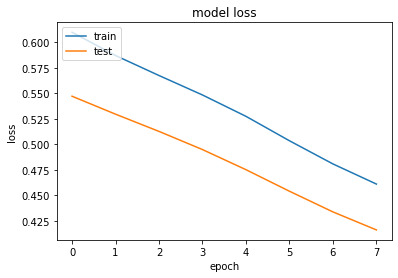

training loss: 0.5357530667684964
Validation loss: 0.4830074588629021


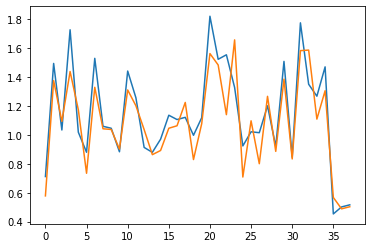

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926


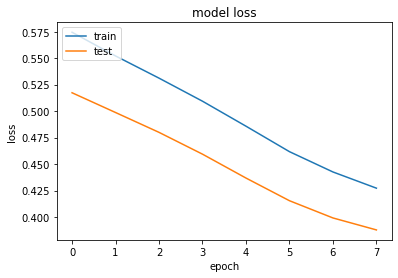

training loss: 0.498066037811146
Validation loss: 0.4493423211049303


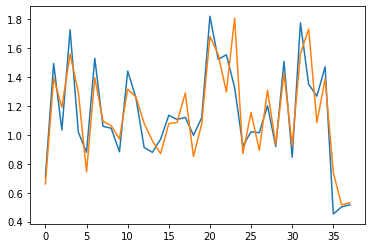

Actual_rmse 0.7481651823259001
Average_rmse 0.1616222382659309
1-Rsquared 0.9515039733038049


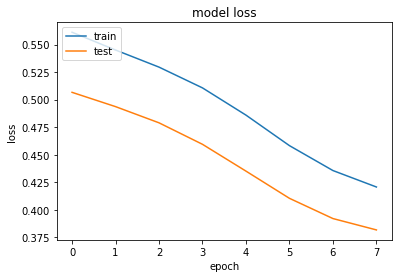

training loss: 0.49336777921776753
Validation loss: 0.4447318882292486


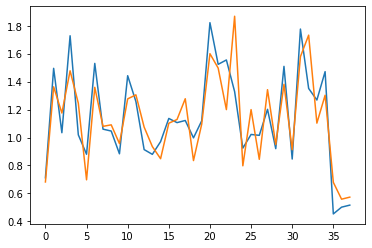

Actual_rmse 0.7401179184321166
Average_rmse 0.1800436278086769
1-Rsquared 0.9502886577009246


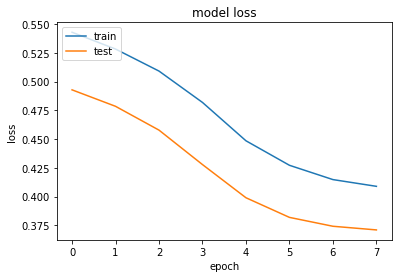

training loss: 0.4701689285219916
Validation loss: 0.4228992934028307


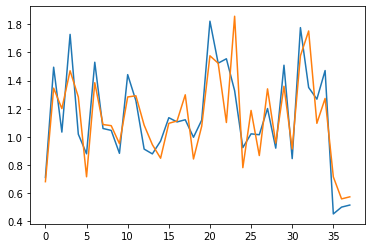

Actual_rmse 0.7383390580368953
Average_rmse 0.19068075135396378
1-Rsquared 0.9583333620904586


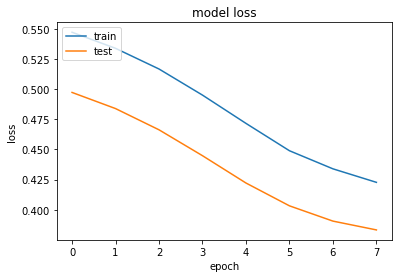

training loss: 0.4836378334159762
Validation loss: 0.4363620015596293


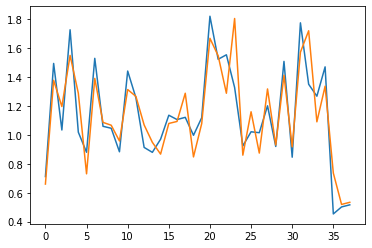

Actual_rmse 0.7451828843244859
Average_rmse 0.16290359635676613
1-Rsquared 0.9512665439798388
0.1558823894815854


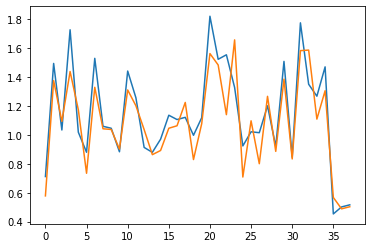

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
TEST ERROR: 0.1558823894815854


In [16]:
def executeModel(data, config, numPoints):
    trainingData = prepareDataset(data, lag, numPoints)
    bestError = 30 #best error idea is got through the benchmark model (e.g. persistence model)
    for j in range(5):
        model = train(trainingData, config)
        error = test(model, data, config, numPoints)
        if error < bestError:
                bestError = error
                model.save(modelName)
    return bestError

lag = 2 #look-back period
trainingDataSize = 1305
config = [lag, 4, 8, 20]
print(executeModel(data, config, trainingDataSize))

model = load_model(modelName)
print("TEST ERROR:",test(model, data, config, trainingDataSize))

Code to save the predictions on test data by loading the model

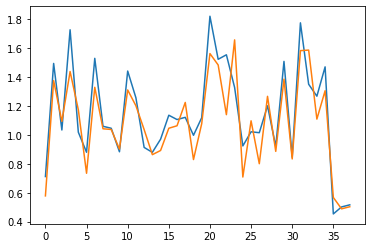

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 0.1558823894815854
bestError: 

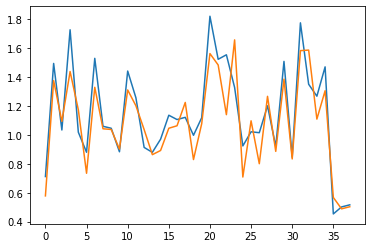

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


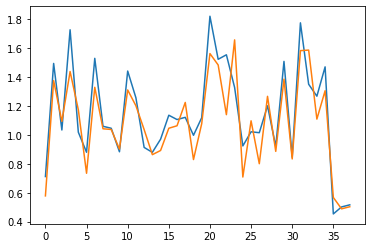

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


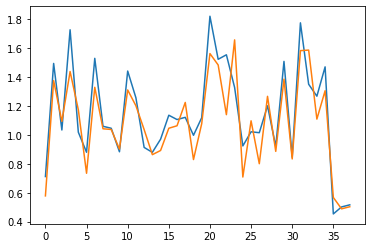

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


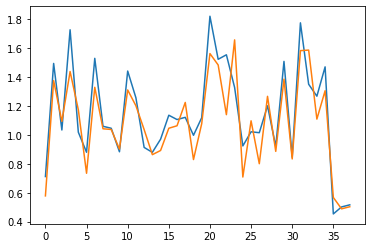

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


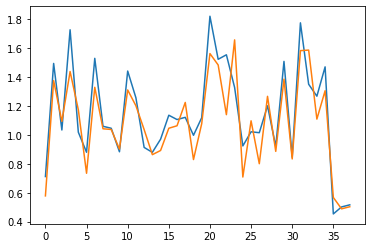

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


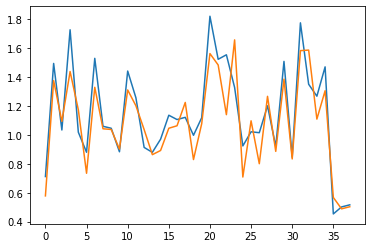

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


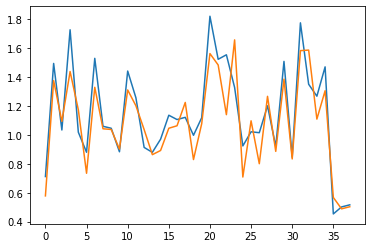

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


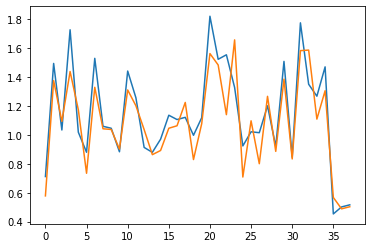

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


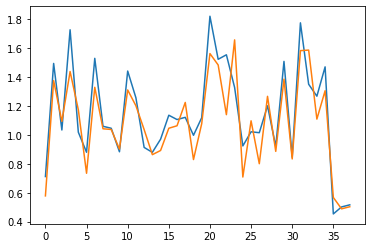

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


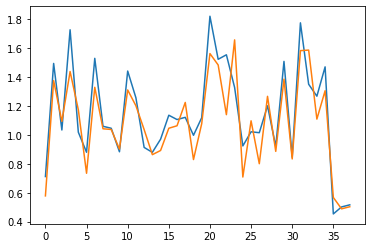

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


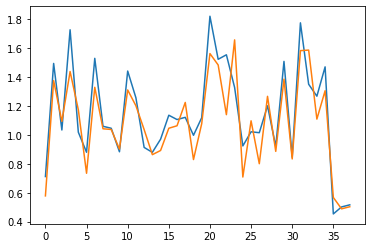

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


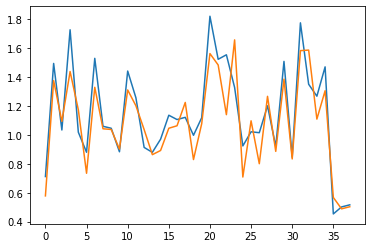

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


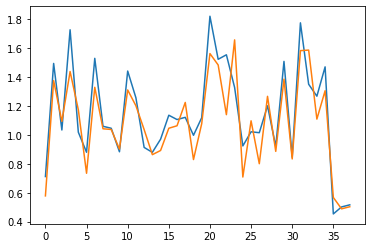

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


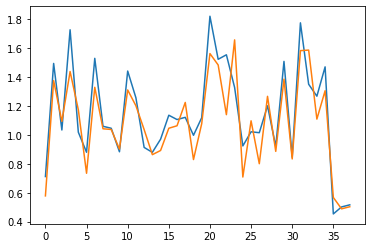

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


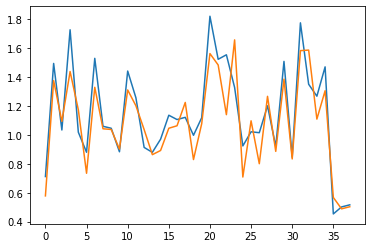

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


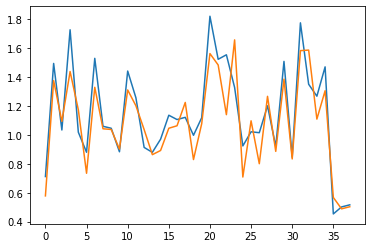

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


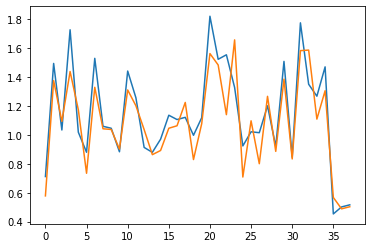

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


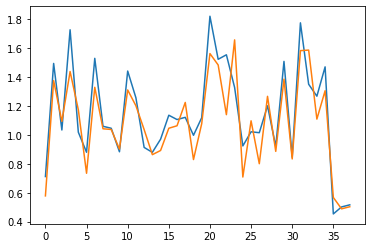

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


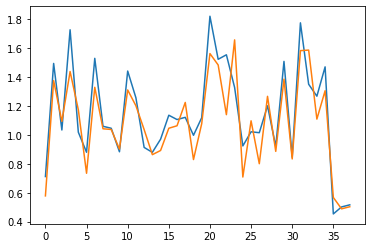

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


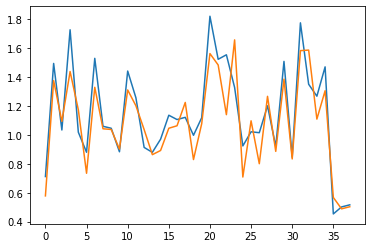

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


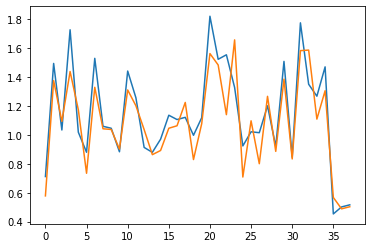

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


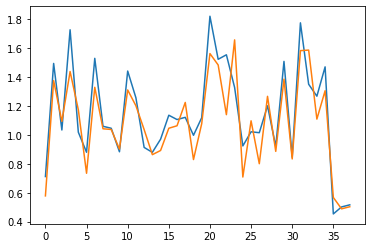

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


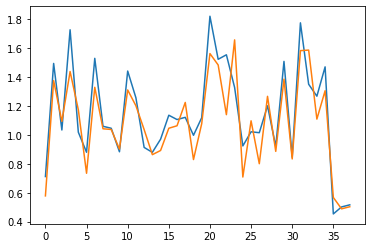

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


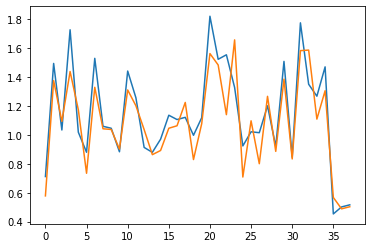

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


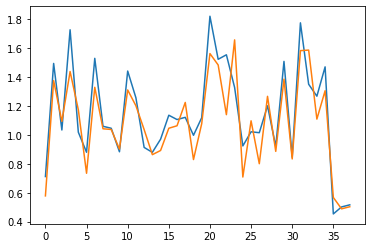

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


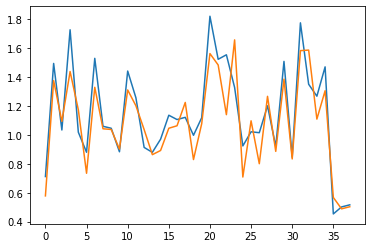

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


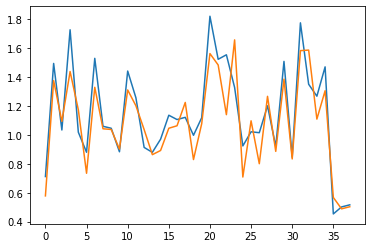

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


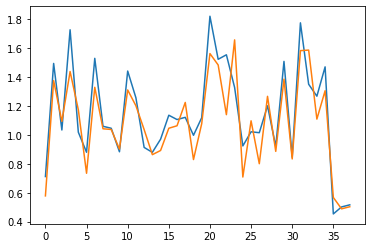

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


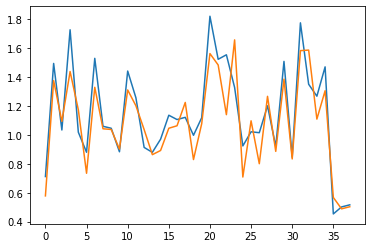

Actual_rmse 0.7603827686622208
Average_rmse 0.1558823894815854
1-Rsquared 0.9443780775911926
error: 0.1558823894815854


In [17]:
import csv as csv
def test(model, data, config, testDataFirstPredictionIndex):
        cnt = 0
        totalError = 0
        lag = config[0]
        testDataStartingIndex = testDataFirstPredictionIndex - lag
        for column in data.columns:
                predictions = list()
                testData = np.array(shiftData(data[column][testDataStartingIndex-1:], lag))
                correction = testData[:, -1]
                if nDiff > 0:
                        testData = np.array(difference(testData))
                testX, testY = testData[:, :-1], testData[:, -1]
                for i in range(testX.shape[0]):
                        predictedVal = predict(model, testX[i], lag)
                        if nDiff > 0:
                                predictedVal = predictedVal + correction[i]
                                testY[i] = testY[i] + correction[i]
                        predictions.append(predictedVal)
                error= measureRmse(testY, predictions, dataAvg[cnt], dataStd[cnt], column)
                totalError += error
                cnt = cnt + 1
        return error,testY, predictions



from keras.models import load_model
best_mod=load_model(modelName)
bestError = 30 #you may have an idea about the best error from a baseline model like persistence model




for _ in range(30):
    error,testval,predictions = test(best_mod, data, config, trainingDataSize)
    print("error:",error)
    if error < bestError:
        bestError = error
        with open('recurrent_test.csv','w') as f:
            writer=csv.writer(f)
            for i in range(len(testval)):
                writer.writerow([testval[i], predictions[i]])
                print('bestError:',bestError)

Code to save the predictions on training data by loading the model

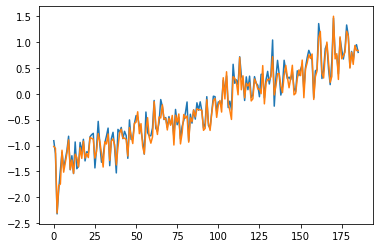

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 

bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError: 0.1272590061621644
bestError:

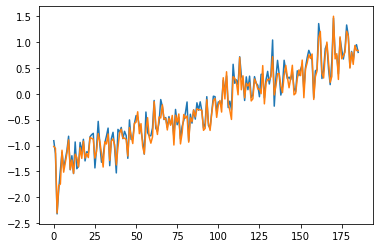

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


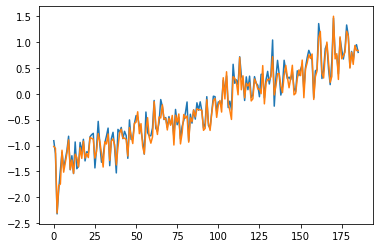

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


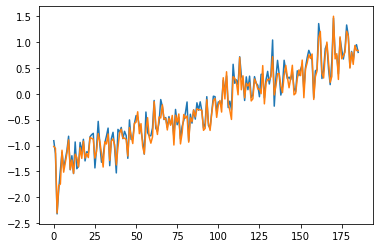

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


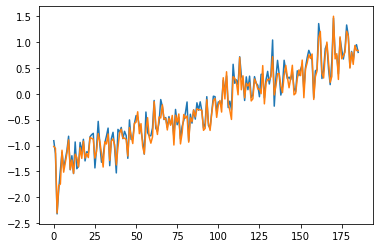

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


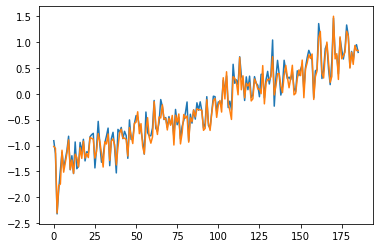

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


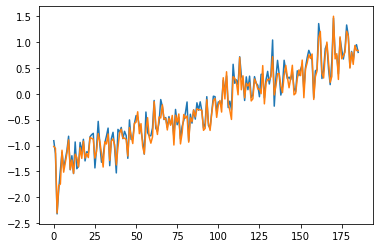

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


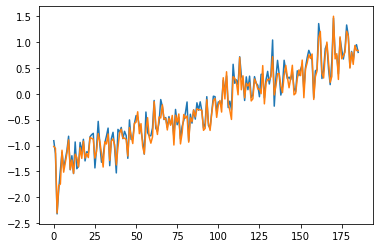

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


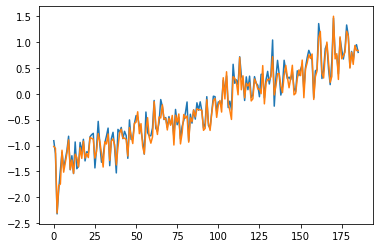

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


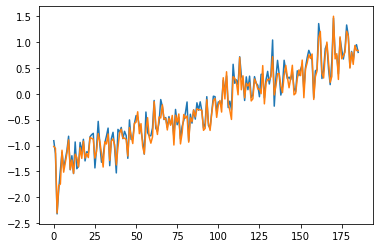

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


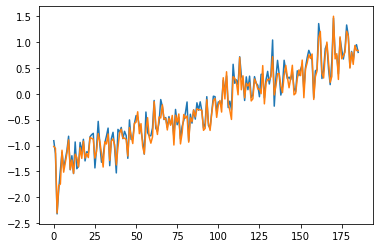

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


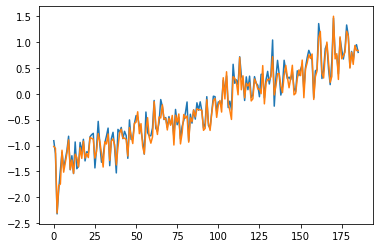

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


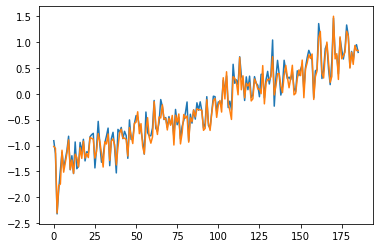

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


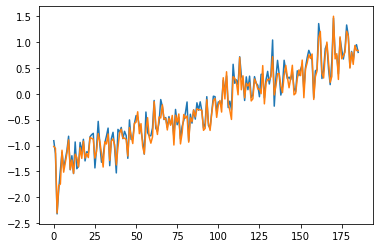

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


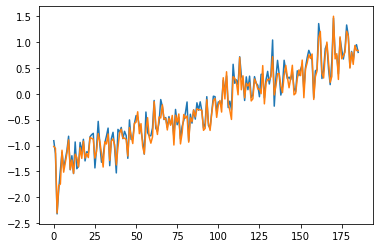

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


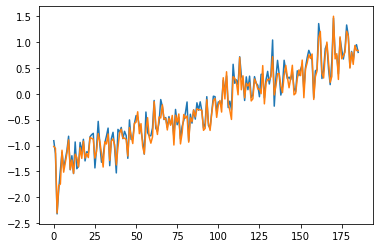

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


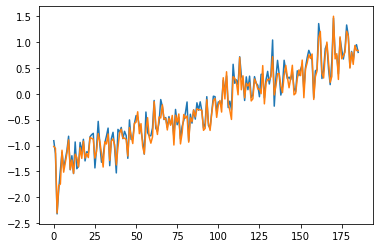

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


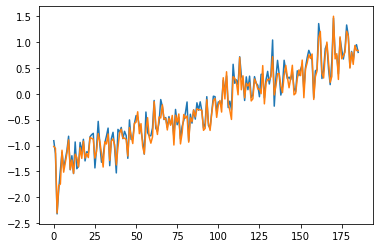

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


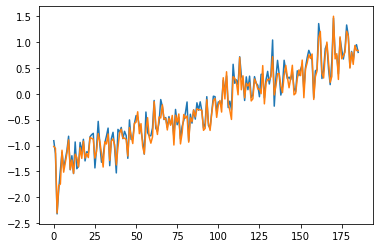

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


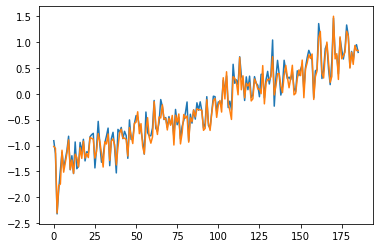

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


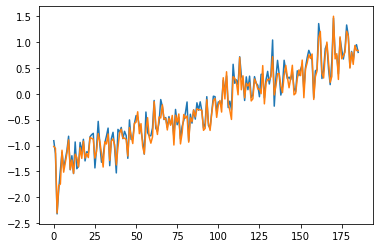

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


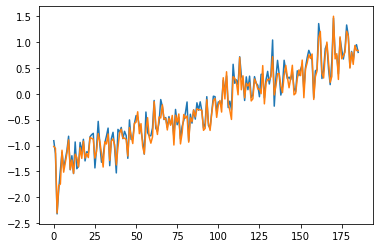

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


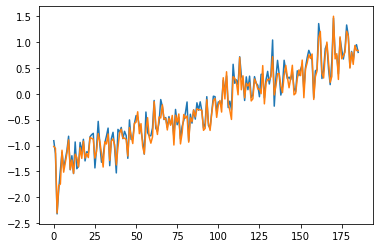

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


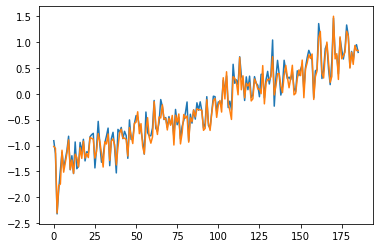

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


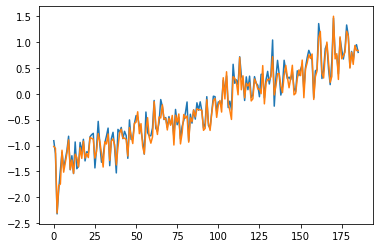

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


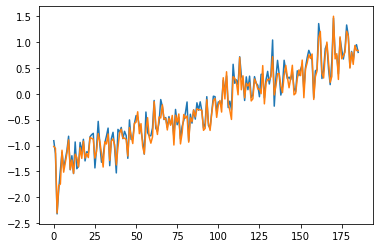

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


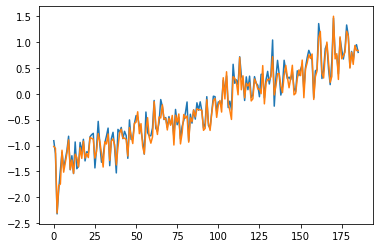

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


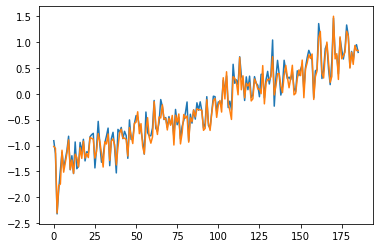

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


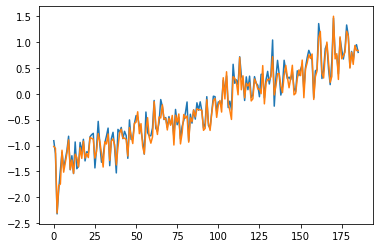

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


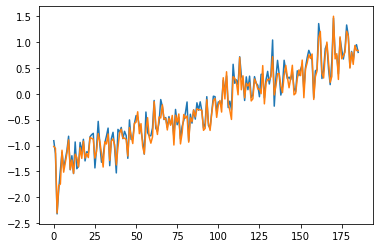

Actual_rmse 0.6673720768764081
Average_rmse 0.1272590061621644
1-Rsquared 0.5173069721971306
error: 0.1272590061621644


In [18]:
import csv as csv
modelName = "lstm_recurrentdrop_B"
def test(model, data, config, testDataFirstPredictionIndex):
        cnt = 0
        totalError = 0
        lag = config[0]
        testDataStartingIndex = 1305 #length of training data
        for column in data.columns:
                predictions = list()                                                           
                testData = np.array(shiftData(data[column][:testDataStartingIndex], lag))
                correction = testData[:, -1]
                if nDiff > 0:
                        testData = np.array(difference(testData))
                testX, testY = testData[:, :-1], testData[:, -1]
                for i in range(testX.shape[0]):
                        predictedVal = predict(model, testX[i], lag)
                        if nDiff > 0:
                                predictedVal = predictedVal + correction[i]
                                testY[i] = testY[i] + correction[i]
                        predictions.append(predictedVal)
                error= measureRmse(testY, predictions, dataAvg[cnt], dataStd[cnt], column)
                totalError += error
                cnt = cnt + 1
        return error,testY, predictions



from keras.models import load_model
best_mod=load_model(modelName)



for _ in range(30):
    error,testval,predictions = test(best_mod, data, config, trainingDataSize)
    print("error:",error)
    if error < bestError:
        bestError = error
        with open('recurrent_train.csv','w') as f:
            writer=csv.writer(f)
            for i in range(len(testval)):
                writer.writerow([testval[i], predictions[i]])
                print('bestError:',bestError)